In [1]:
import sys
sys.path.insert(0,'..')

# Compute Sentiments

In [2]:
# import pandas as pd
# from transformers import pipeline

# # Instantiate model
# nlp = pipeline('sentiment-analysis', model='finiteautomata/bertweet-base-sentiment-analysis')

# # Get headlines
# df = pd.read_csv('path/to/cleaned/data')
# headlines = list(df['headline'])

# # Compute sentiments
# sentiments = nlp(headlines, return_all_scores=True)
# sent_list = [{'neg': neg['score'], 'neu': neu['score'], 'pos': pos['score']} for neg, neu, pos in sentiments]
# sent_df = pd.DataFrame(sent_list)

# # Add sentiments to data
# df = pd.concat([df, sent_df], axis=1)

# Compute Embeddings 

In [3]:
import pandas as pd
from src import embeddings

df = pd.read_csv('../output/exploratory_v2.csv')
headlines = list(df['headline'])

In [4]:
# hl_embeddings = embeddings.bert(headlines)

In [5]:
# normalize df['ctr']
mu = df['ctr'].mean()
sigma = df['ctr'].std()

df['ctr']=(df['ctr']-mu)/sigma
df['ctr']

0        2.039539
1        0.733794
2        1.417338
3        1.006305
4        0.429059
           ...   
18967    0.139135
18968   -0.413325
18969   -0.546960
18970   -0.654876
18971   -0.882459
Name: ctr, Length: 18972, dtype: float64

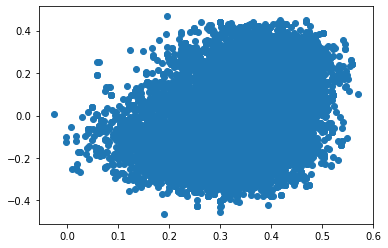

In [6]:
import pickle
import numpy as np

hle_fname = '../output/hl_embeddings.pkl'
hl_embeddings = pickle.load(open(hle_fname, "rb"))
embeddings.plot(hl_embeddings)

In [7]:
X = np.array(hl_embeddings)
y = np.array(df['ctr'].tolist())

# Predict 

In [8]:
import torch
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader

class PackagesDataset(torch.utils.data.Dataset):
    """
    Prepare the Packages dataset for regression
    """

    def __init__(self, X, y, scale_data=True):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            # Apply scaling if necessary
            if scale_data:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]


class MLP(nn.Module):
    """
      Multilayer Perceptron for regression.
    """

    def __init__(self, in_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        """
          Forward pass
        """
        return self.layers(x)

In [9]:
%%capture

NB_EPOCHS = 50
# Set fixed random number seed
torch.manual_seed(42)

# Load Packages dataset
# X, y = load_packages()

# Prepare Packages dataset
dataset = PackagesDataset(X, y)

# Split Packages dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create trainloader object
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=1)

# Create testloader object
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=1)

# Initialize the MLP
mlp = MLP(in_size=X.shape[1])

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)


losses = {'train': [], 'test': []}
epochs = range(NB_EPOCHS)


def train(epoch):
     # Print epoch
    print(f'Starting epoch {epoch + 1}')

    mlp.train()
    
    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):

        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = mlp(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
    
    current_loss /= len(trainloader)
    
    losses['train'].append(current_loss)
    
    print('Train Loss: %.3f'%(current_loss))

    
def test(epoch):
    mlp.eval()

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):

        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        # Perform forward pass
        outputs = mlp(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
    
    current_loss /= len(testloader)
    
    losses['test'].append(current_loss)
    
    print('Test Loss: %.3f'%(current_loss))

# Run the training loop
for epoch in epochs:
    train(epoch)
    test(epoch)

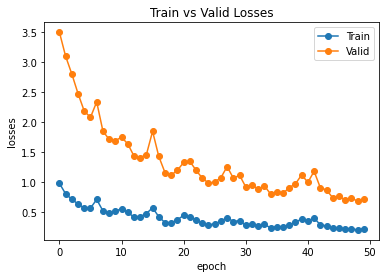

In [10]:
import matplotlib.pyplot as plt

plt.plot(losses['train'],'-o')
plt.plot(losses['test'],'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
 
plt.show()

# Correlations between hl_sent, ex_sent, ctr

In [11]:
# import seaborn as sns

# df = pd.read_csv('../output/exploratory_v2.csv')

# df=(df-df.mean())/df.std()

# data = df[['ctr', 'h_neu', 'h_pos', 'h_neg']]
# g = sns.pairplot(data)
# g.fig.suptitle(f'ctr correlation with headline sentiment', y=1.05)

# Examples

In [30]:
headlines = [
    'Oxford is better than Harvad, Here is why.',
    'Prince of Sussex is having dinner in Paris tonight.',
    'This will blow your mind!',
    '10 Ways to get rich without working.',
    '208 Catchy Headlines & Attention Grabbing Blog Title',
    'maybe even day of week might influence stuff',
    "A Science Guy Helps 3 Dudes From America Understand What They're Really Up Against",
]

In [31]:
hl_embeddings = embeddings.bert(headlines)

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [32]:
X = np.array(hl_embeddings)

mlp(torch.tensor(X))*sigma + mu

tensor([[0.0180],
        [0.0179],
        [0.0180],
        [0.0182],
        [0.0181],
        [0.0179],
        [0.0180],
        [0.0181]], grad_fn=<AddBackward0>)